In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from indicator_simulation_modify_noise import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


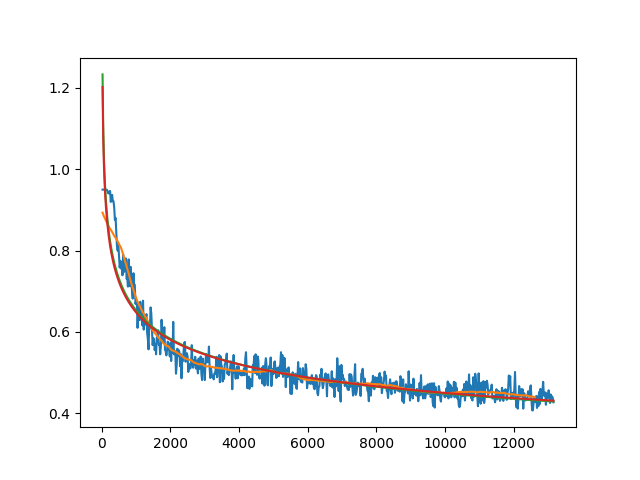

0.8065542774444276

In [15]:
# data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 10
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
smoothed_steps = (np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval
plt.figure()
plt.plot(steps, val_err)
plt.plot(smoothed_steps, whole_smoothed_val_err)

a, b = power_regression(steps, val_err, np.ones(len(steps)))
plt.plot(steps, power_function(steps, a, b))

a, b = power_regression(smoothed_steps, whole_smoothed_val_err, np.ones(len(smoothed_steps)))
plt.plot(steps, power_function(steps, a, b))

np.mean(val_err[:55])

In [3]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])
# earlyStoppingStep = 9220

9220 0.32954545454545453 505
9600 0.34330909035422585


<IPython.core.display.Javascript object>


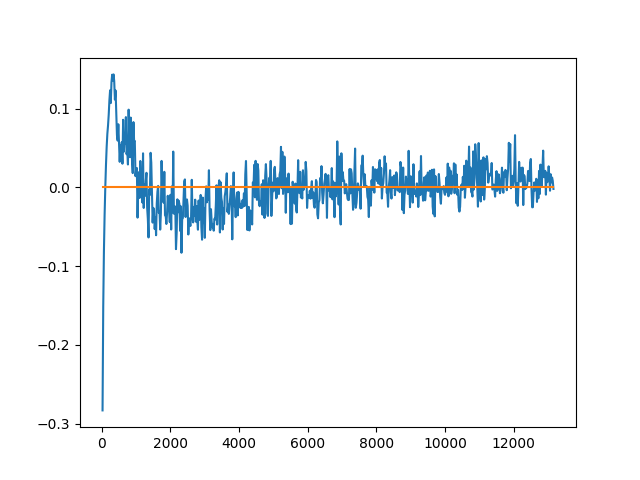

<IPython.core.display.Javascript object>


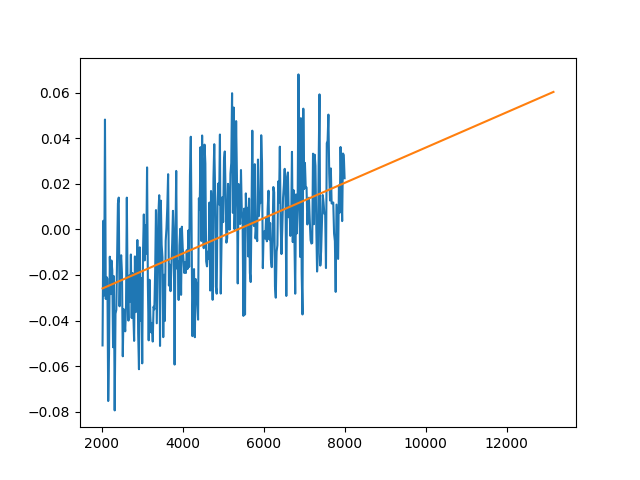

0.2510719781872765
63.45465724268891 0.002774642698302141


<IPython.core.display.Javascript object>


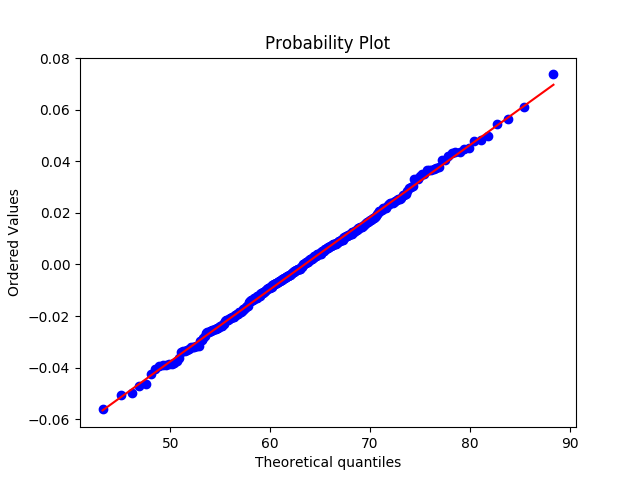

<IPython.core.display.Javascript object>


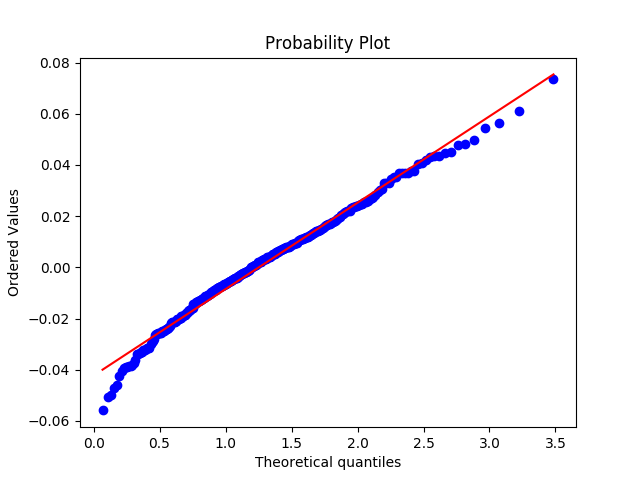

<IPython.core.display.Javascript object>


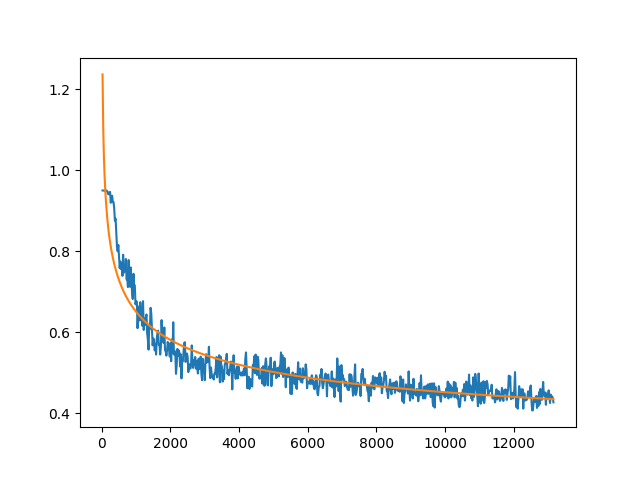

In [19]:
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
err = val_err-whole_a*np.power(steps,whole_b)
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

max_steps = 400
plt.figure()
whole_a, whole_b = power_regression(steps[:max_steps], val_err[:max_steps], np.ones(len(steps[:max_steps])))
err = val_err[:max_steps]-whole_a*np.power(steps[:max_steps],whole_b)
ax = plt.subplot()
ax.plot(steps[100:max_steps], err[100:])
err_a, err_b = np.linalg.lstsq(np.vstack([steps[100:max_steps], np.ones(len(steps[100:max_steps]))]).T, err[100:], rcond=None)[0]
ax.plot(steps[100:], err_a*steps[100:] + err_b)


res = err[100:] - err_a*steps[100:max_steps] - err_b
# res = val_err[smooth_win_size//2+500:smooth_win_size//2+800] - whole_smoothed_val_err[500:800]
skew = scipy.stats.skew(res)
print(skew)
k = (2/skew)**2
theta = np.sqrt(np.var(res)/k)
print(k, theta)

plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.gamma(k, theta), plot=plt)
plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.rayleigh, plot=plt)

plt.figure()
plt.plot(steps, val_err)

fun = lambda x: np.sum(np.power(val_err-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]*(steps-x[3])),2))
bnds = ((0, None), (None, 0), (0, None),(0, None))
res = scipy.optimize.minimize(fun, (1,0,0,8000), method='TNC', bounds=bnds)

plt.plot(steps,(res.x[0]*np.power(steps, res.x[1])+res.x[2]*(steps-res.x[3])))

<IPython.core.display.Javascript object>


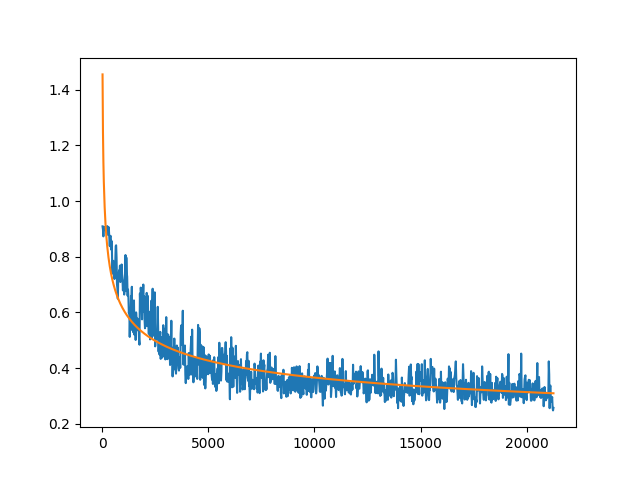

In [76]:
plt.figure()
plt.plot(steps, val_err)

fun = lambda x: np.sum(np.power(val_err-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]*(steps-x[3])),2))
bnds = ((0, None), (None, 0), (0, None),(0, None))
res = scipy.optimize.minimize(fun, (1,0,0,8000), method='TNC', bounds=bnds)

plt.plot(steps,(res.x[0]*np.power(steps, res.x[1])+res.x[2]*(steps-res.x[3])))


In [ ]:
pred_win_size = 1000
left_tail_size = 0
period = 20
start_point = 5
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000
bnds = ((0, None), (None, 0))
inits = (1,0)
noise_est_win_size = 300
patience = patience

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5
preds_with_patience = []
errs_with_patience = []

# patiences = range(13,14)
# for patience in patiences:
# using smoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=True,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)


1180
Predicted Stopping epoch is 7337.92. a = 1.5056799996532368, b = -0.08853076523428802, d^2=0, skew=-1.1171244131652156, mean=-0.07328212090897371
1580
Predicted Stopping epoch is 8793.98. a = 1.7442760190571451, b = -0.11126461974006566, d^2=0, skew=-1.5317162456482767, mean=-0.09546281237286025
1980
Predicted Stopping epoch is 14366.58. a = 2.485897195494665, b = -0.1645548637842049, d^2=0, skew=-2.406555615358517, mean=-0.12690911809488523
2380
Predicted Stopping epoch is 24591.56. a = 4.529786433426685, b = -0.2535528623760689, d^2=0, skew=-3.3818705446799497, mean=-0.16505574790905597
2780
Predicted Stopping epoch is 29336.0. a = 5.811457123032569, b = -0.289948707999001, d^2=0, skew=-3.7052828368879, mean=-0.15740234772687128
3180
Predicted Stopping epoch is 30118.36. a = 6.49625017851846, b = -0.3060320906729799, d^2=0, skew=-3.954586854735637, mean=-0.14421535198309682
3580
Predicted Stopping epoch is 30235.82. a = 6.6653979752919374, b = -0.30968454738143225, d^2=0, skew=-

In [ ]:
fig = plt.figure()

x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
x_smooth = (x+ (smooth_win_size-1) * num_epochs_between_eval)[:len(preds_with_patience[0])]
print(x_smooth)

plt.plot(x, earlyStoppingStep-x,'-o')

legend = ['Ground truth']
# for i, v in enumerate(patiences):
#     plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
#     legend.append('Indicator: patience = {}'.format(v))

for i in range(2): 
    if i == 0 or i == 2:
#         x_smooth = x + smooth_win_size * num_epochs_between_eval
        plt.errorbar(x_smooth, preds_with_patience[i]-x_smooth, errs_with_patience[i], fmt='.-')
#         plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
        legend.append('regression on smoothed curve')
    else:
        plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
        legend.append('regression on original curve')

plt.xlim(0,earlyStoppingStep+100)

plt.legend(legend)
plt.title('no lr decay;\n pred_win_size = {0}, period = {1}\n min_delta = {2}, smooth_win_size = {4}'.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

plt.savefig('/Users/stranot/Desktop/gamma_noise_test.png')

In [ ]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 4
for i in range(0,len(coeffs),step_size):
#     co += 1
#     ax = plt.subplot(4,4, co)
#     ax.set_ylim(0, 1.5)
# #     ax.plot(steps, val_err)
#     ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
#     x = np.arange(1,len(smoothed_samples[i])+1)*num_epochs_between_eval
# #     ax.plot(x,smoothed_samples[i])
#     ax.plot(x+shifts[i],smoothed_samples[i])
# #     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
#     e = (start_point + i*period)*num_epochs_between_eval
#     s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
#     ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
#     ax.set_xlim(-500,80000)
    
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
    ax.plot(steps, val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)],power_function(steps[:len(whole_smoothed_val_err)], coeffs[i][0], coeffs[i][1]))
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x+shifts[i],samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,80000)
    
fig.tight_layout()   